In [98]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils import shuffle
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer


# https://erdogant.github.io/distfit/pages/html/Parametric.html

In [86]:
adult = fetch_openml('adult')

c:\Users\vitos\anaconda3\envs\python38\lib\site-packages\sklearn\datasets\_openml.py:292: UserWarning: Multiple active versions of the dataset matching the name adult exist. Versions may be fundamentally different, returning version 1.
  warn(


In [87]:
X = adult['data']
y = adult['target']

In [88]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  category
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  float64 
 3   education       48842 non-null  category
 4   education-num   48842 non-null  float64 
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capitalgain     48842 non-null  category
 11  capitalloss     48842 non-null  category
 12  hoursperweek    48842 non-null  category
 13  native-country  47985 non-null  category
dtypes: category(12), float64(2)
memory usage: 1.3 MB


In [89]:

num_features = X.select_dtypes(include='number').columns.to_list()
cat_features = X.select_dtypes(exclude='number').columns.to_list()

cardinalitites = [
    X[f].nunique()
    for f in cat_features
]

max_one_hot = 10
oh_cat_features = [cat_features[i] for i,c in enumerate(cardinalitites) if c<=max_one_hot]
ord_cat_features = [cat_features[i] for i,c in enumerate(cardinalitites) if c>max_one_hot]

# Optionally
# shuffled_features = X.columns.to_list()[:2]

# shuffled_num_features = X[shuffled_features].select_dtypes(include='number').columns.to_list()
# shuffled_cat_features = X[shuffled_features].select_dtypes(exclude='number').columns.to_list()

# shuffled_cardinalitites = [
#     X[f].nunique()
#     for f in cat_features
# ]
# shuffled_oh_cat_features = [cat_features[i] for i,c in enumerate(cardinalitites) if c<=max_one_hot]
# shuffled_ord_cat_features = [cat_features[i] for i,c in enumerate(cardinalitites) if c>max_one_hot]


In [148]:
# Generate random features

# plt.hist(
    # np.random.normal(size=(X.shape[0],1))
    # np.random.random(size=(X.shape[0],1))
    # np.random.exponential(size=(X.shape[0],1))
    # np.random.choice([i for i in range(10)], size=(X.shape[0],1))
    #  np.random.binomial(n=1, p=0.7, size=(X.shape[0],1))   
# )

x_norm = pd.DataFrame(np.random.normal(size=(X.shape[0],1)), columns=['x_norm']) 
# x_rand = pd.DataFrame(np.random.random(size=(X.shape[0],1)), columns=['x_rand'])
# x_exp = pd.DataFrame(np.random.exponential(size=(X.shape[0],1)), columns=['x_exp'])
# x_choice = pd.DataFrame(np.random.choice([i for i in range(10)], size=(X.shape[0],1)), columns=['x_choice'])
x_binom = pd.DataFrame(np.random.binomial(n=1, p=0.7, size=(X.shape[0],1))  , columns=['x_binom'])

X_random = pd.concat(
    [x_norm,
    # x_rand,
    # x_exp,
    # x_choice,
    x_binom
    ], axis=1)

random_features = X_random.columns.to_list()

random_features

['x_norm', 'x_binom']

In [149]:
X_full = pd.concat([
    X,
    X_random
],axis=1)


In [150]:
col_transformer = ColumnTransformer([
    ('oh_cat_features',make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(sparse=False)), oh_cat_features),
    ('ord_cat_features',make_pipeline(SimpleImputer(strategy='most_frequent'),OrdinalEncoder()), ord_cat_features),
    ('num_features', make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), num_features),
])

# shuffle_col_transformer = ColumnTransformer([
#     ('shuffled_features', FunctionTransformer(func=shuffle, feature_names_out ='one-to-one'), shuffled_features),
# ])

random_col_transformer = ColumnTransformer([
    ('random_features', 'passthrough', random_features)  
])


fu = FeatureUnion([
    (
        'fu_col', 
        col_transformer
    ),
    # (
    #     'fu_shuffled_col',
    #     shuffle_col_transformer
    # ),
    (
        'fu_random_col',
        random_col_transformer
    ),
])

# col_transformer.fit_transform(X_full)

X_full_enc = fu.fit_transform(X_full)

feature_names = list(fu.get_feature_names_out())

In [151]:
X_full_enc = pd.DataFrame(X_full_enc, columns=feature_names)

In [152]:
random_feature_names = [f for f in feature_names if 'random' in f]
random_feature_idx = [feature_names.index(f) for f in random_feature_names]

In [153]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_enc = label_encoder.fit_transform(y)


In [154]:
rf = RandomForestClassifier()

rf.fit(X_full_enc, y_enc)

RandomForestClassifier()

<BarContainer object of 55 artists>

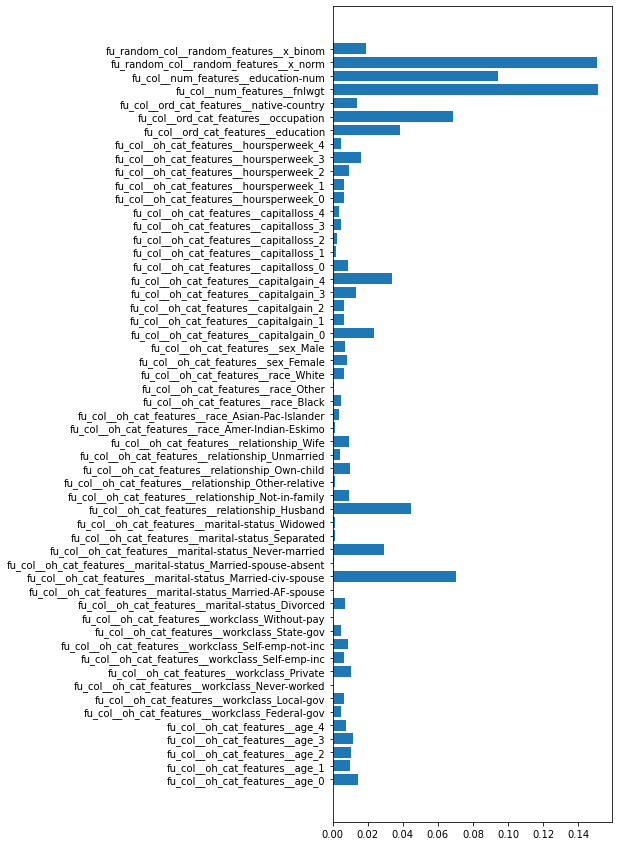

In [158]:
random_features_ = [f for f in rf.feature_names_in_ if 'random' in f]

rf.feature_names_in_[random_feature_idx]

rf.feature_importances_[rf.feature_importances_ >= max(rf.feature_importances_[random_feature_idx])]
rf.feature_names_in_[rf.feature_importances_ >= max(rf.feature_importances_[random_feature_idx])]

plt.figure(figsize=(5,15))
plt.barh(rf.feature_names_in_,rf.feature_importances_)
# plt.barh(
    # rf.feature_names_in_[rf.feature_importances_ > max(rf.feature_importances_[random_feature_idx])],
    # rf.feature_importances_[rf.feature_importances_ > max(rf.feature_importances_[random_feature_idx])]  
# )